In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from pydtmc import MarkovChain

from ipywidgets import interact, Dropdown

DATA_DIR = 'data'

In [2]:
# Create mapping course_id -> course name/short name

class SmartMap(dict):
    def __missing__(self, key):
        return f"Unknown({key})"
    
course_map = SmartMap({
    42 : 'Langzeitgymnasium maths',
    3865 : 'Kurzzeitgymnasium maths',
    5447 : 'Langzeitgymnasium essay',
    2115 : 'Langzeitgymnasium text comprehension',
    5009 : 'Kurzzeitgymnasium text comprehension',
    3301 : 'Kurzzeitgymnasium essay',
    1696 : 'Student site introduction',
    8117 : 'Teacher site introduction'
})

course_map_short = SmartMap({
    42 : 'LZG_M',
    3865 : 'KZG_M',
    5447 : 'LZG_E',
    2115 : 'LZG_TC',
    5009 : 'KZG_TC',
    3301 : 'KZG_E',
    1696 : 'SSI',
    8117 : 'TSI'
})

In [3]:
activities = pd.read_csv(f'{DATA_DIR}/activity.csv')
activities = activities.dropna(subset='activity_started')
activities.sort_values(by=['user_id', 'activity_started'], ascending=True, inplace=True)

In [4]:
activities['state'] = activities['activity_type'] + '_' + activities['course_id'].map(course_map_short).fillna('Unknown')
activities['duration'] = np.where(activities['activity_started'].notna() & activities['activity_completed'].notna() & 
                                  (activities['activity_completed']>= activities['activity_started']),
                                  activities['activity_completed'] - activities['activity_started'], np.nan)

state_to_idx = {s: i for i, s in enumerate(activities['state'].unique())}
activities['state_idx'] = activities['state'].map(state_to_idx)

activities['next_state_idx'] = activities.groupby('user_id')['state_idx'].shift(-1)
transitions = activities.dropna(subset=['next_state_idx']).copy()
transitions['next_state_idx'] = transitions['next_state_idx'].astype(int)

all_states = activities['state'].unique().tolist()
n_states = len(all_states)


In [5]:
# Per-user Markov chains
user_chains = {}

for user_id, group in transitions.groupby('user_id'):
    matrix = np.zeros((n_states, n_states), dtype=float)
    # Vectorized accumulation of transition counts
    np.add.at(matrix, (group['state_idx'], group['next_state_idx']), 1)
    
    # Normalize rows and handle dead-end states with self-loops
    row_sums = matrix.sum(axis=1, keepdims=True)
    for idx, row_sum in enumerate(row_sums.flatten()):
        if row_sum == 0:
            matrix[idx, idx] = 1  # Self-loop
        else:
            matrix[idx] /= row_sum  # Normalize row to sum to 1
    
    mc = MarkovChain(matrix.tolist(), all_states)
    user_chains[user_id] = mc

# ✅ Example: Inspect User 1's Model
print(f"User 1 Transition Matrix:\n{np.round(user_chains[1].p, 2)}")
print(f"States: {user_chains[1].states}")


User 1 Transition Matrix:
[[0.   1.   0.   ... 0.   0.   0.  ]
 [0.   0.43 0.29 ... 0.   0.   0.  ]
 [0.   0.09 0.64 ... 0.   0.   0.  ]
 ...
 [0.   0.   0.   ... 1.   0.   0.  ]
 [0.   0.   0.   ... 0.   1.   0.  ]
 [0.   0.   0.   ... 0.   0.   1.  ]]
States: ['course_KZG_E', 'lesson_KZG_E', 'topic_KZG_E', 'course_KZG_TC', 'lesson_KZG_TC', 'topic_KZG_TC', 'quiz_KZG_E', 'course_KZG_M', 'lesson_KZG_M', 'topic_KZG_M', 'quiz_KZG_M', 'exam_LZG_E', 'access_SSI', 'topic_Unknown(0)', 'access_KZG_TC', 'course_LZG_E', 'course_LZG_TC', 'course_LZG_M', 'access_LZG_E', 'access_LZG_TC', 'access_LZG_M', 'lesson_LZG_M', 'topic_LZG_M', 'quiz_LZG_M', 'lesson_LZG_TC', 'topic_LZG_TC', 'lesson_LZG_E', 'topic_LZG_E', 'quiz_LZG_E', 'course_SSI', 'lesson_SSI', 'topic_SSI', 'access_TSI', 'course_TSI', 'lesson_TSI', 'topic_TSI', 'access_KZG_E', 'access_KZG_M', 'group_progress_Unknown(0)', 'exam_KZG_E', 'lesson_Unknown(0)', 'exam_LZG_TC', 'exam_KZG_TC', 'course_Unknown(2019)', 'lesson_Unknown(2019)', 'topic_Un

In [6]:
import ipywidgets as widgets
import networkx as nx
import plotly.graph_objs as go
from IPython.display import display
import numpy as np

def plot_user_markov_with_edge_labels(user_id):
    mc = user_chains[user_id]
    matrix = np.array(mc.p)
    states = mc.states

    # Identify non-trivial states
    non_trivial_states = set()
    for i, state in enumerate(states):
        row = matrix[i]
        col = matrix[:, i]
        if not (np.isclose(row[i], 1.0) and np.isclose(row.sum(), 1.0) and np.isclose(col.sum(), 1.0)):
            non_trivial_states.add(state)

    # Build filtered graph
    G = nx.DiGraph()
    for i, from_state in enumerate(states):
        if from_state not in non_trivial_states:
            continue
        for j, to_state in enumerate(states):
            if to_state in non_trivial_states and matrix[i, j] > 0:
                G.add_edge(from_state, to_state, weight=round(matrix[i, j], 2))

    if len(G.nodes) == 0:
        print(f"No significant transitions to visualize for User {user_id}.")
        return

    pos = nx.circular_layout(G)

    # Edge Traces
    edge_trace = []
    edge_labels = []

    for edge in G.edges(data=True):
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        weight = edge[2]['weight']
        # Add edge line
        edge_trace.append(go.Scatter(
            x=[x0, x1], y=[y0, y1],
            line=dict(width=2, color='gray'),
            mode='lines',
            hoverinfo='none'
        ))
        # Add edge label at midpoint
        mid_x, mid_y = (x0 + x1) / 2, (y0 + y1) / 2
        edge_labels.append(go.Scatter(
            x=[mid_x], y=[mid_y],
            text=[f"{weight}"],
            mode='text',
            hoverinfo='none',
            textposition='top center'
        ))

    # Node Trace
    node_trace = go.Scatter(
        x=[pos[node][0] for node in G.nodes()],
        y=[pos[node][1] for node in G.nodes()],
        text=list(G.nodes()),
        mode='markers+text',
        textposition='bottom center',
        marker=dict(size=30, color='lightblue', line=dict(width=2, color='darkblue'))
    )

    fig = go.Figure(data=edge_trace + edge_labels + [node_trace],
                    layout=go.Layout(
                        title=f"User {user_id} Markov Model (Non-Trivial States)",
                        showlegend=False,
                        hovermode='closest',
                        margin=dict(t=50, l=25, r=25, b=25),
                        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
                    ))
    fig.show()

# Interactive widget
user_selector = widgets.Dropdown(
    options=sorted(user_chains.keys()),
    description='User ID:',
    continuous_update=False
)

out = widgets.Output()

def on_user_change(change):
    with out:
        out.clear_output(wait=True)
        plot_user_markov_with_edge_labels(change['new'])

user_selector.observe(on_user_change, names='value')

display(user_selector, out)

# Auto-trigger initial plot
user_selector.value = sorted(user_chains.keys())[0]


Dropdown(description='User ID:', options=(1, 4, 5, 6, 7, 9, 10, 11, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 28…

Output()

In [7]:
from scipy.spatial.distance import jensenshannon
import numpy as np
import pandas as pd

# Assume user_chains is a dict: user_id -> MarkovChain object (with mc.p as transition matrix)
user_ids = list(user_chains.keys())
n_users = len(user_ids)

# Preallocate distance matrix
distance_matrix = np.zeros((n_users, n_users))

# Compute pairwise Jensen-Shannon Divergence
for i in range(n_users):
    for j in range(i + 1, n_users):
        m1 = np.array(user_chains[user_ids[i]].p)
        m2 = np.array(user_chains[user_ids[j]].p)
        
        # Flatten matrices row-wise (or you can aggregate row distributions)
        p = m1.flatten()
        q = m2.flatten()
        
        # Ensure distributions sum to 1
        if p.sum() > 0: p = p / p.sum()
        if q.sum() > 0: q = q / q.sum()
        
        jsd = jensenshannon(p, q, base=2)  # Base 2 for distance in [0, 1]
        distance_matrix[i, j] = jsd
        distance_matrix[j, i] = jsd


In [8]:
import hdbscan

clusterer = hdbscan.HDBSCAN(metric='precomputed', min_cluster_size=2)
labels = clusterer.fit_predict(distance_matrix)


/opt/homebrew/Caskroom/miniconda/base/envs/gogymi/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/gogymi/lib/python3.11/site-packages/umap/umap_.py:1857: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


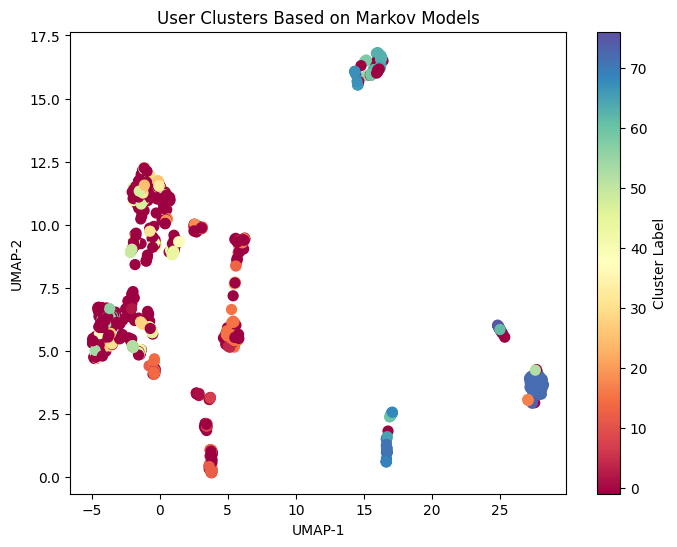

In [9]:
import umap.umap_ as umap
import matplotlib.pyplot as plt

# Embed distance matrix into 2D space
embedding = umap.UMAP(metric='precomputed').fit_transform(distance_matrix)

# Plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=labels, cmap='Spectral', s=50)
plt.colorbar(scatter, label='Cluster Label')
plt.title('User Clusters Based on Markov Models')
plt.xlabel('UMAP-1')
plt.ylabel('UMAP-2')
plt.show()


In [ ]:
activities

States Mapping: {'course_KZG_E': 0, 'lesson_KZG_E': 1, 'topic_KZG_E': 2, 'course_KZG_TC': 3, 'lesson_KZG_TC': 4, 'topic_KZG_TC': 5, 'quiz_KZG_E': 6, 'course_KZG_M': 7, 'lesson_KZG_M': 8, 'topic_KZG_M': 9, 'quiz_KZG_M': 10, 'exam_LZG_E': 11, 'access_SSI': 12, 'topic_Unknown(0)': 13, 'access_KZG_TC': 14, 'course_LZG_E': 15, 'course_LZG_TC': 16, 'course_LZG_M': 17, 'access_LZG_E': 18, 'access_LZG_TC': 19, 'access_LZG_M': 20, 'lesson_LZG_M': 21, 'topic_LZG_M': 22, 'quiz_LZG_M': 23, 'lesson_LZG_TC': 24, 'topic_LZG_TC': 25, 'lesson_LZG_E': 26, 'topic_LZG_E': 27, 'quiz_LZG_E': 28, 'course_SSI': 29, 'lesson_SSI': 30, 'topic_SSI': 31, 'access_TSI': 32, 'course_TSI': 33, 'lesson_TSI': 34, 'topic_TSI': 35, 'access_KZG_E': 36, 'access_KZG_M': 37, 'group_progress_Unknown(0)': 38, 'exam_KZG_E': 39, 'lesson_Unknown(0)': 40, 'exam_LZG_TC': 41, 'exam_KZG_TC': 42, 'course_Unknown(2019)': 43, 'lesson_Unknown(2019)': 44, 'topic_Unknown(2019)': 45, 'access_Unknown(2019)': 46, 'course_Unknown(2515)': 47, 'l

/var/folders/tb/xz8bmvcs5mjgtg8nqczpcrcc0000gn/T/ipykernel_5675/2538938083.py:8: RuntimeWarning: invalid value encountered in divide
  matrix = counts / counts.sum(axis=1, keepdims=True)


In [ ]:
activities

In [ ]:
transitions

In [23]:
activities.head()

,Unnamed: 0,activity_id,user_id,post_id,course_id,activity_type,activity_status,activity_started,activity_completed,activity_updated,state,duration
31764,386,76018,1,3301,3301,course,0,1729926184,0.000000e+00,1737787863,course_KZG_E,NaN
31765,387,76019,1,9212,3301,lesson,0,1729926184,NaN,1729926184,lesson_KZG_E,NaN
31796,418,76050,1,3773,3301,lesson,1,1729927563,1.730515e+09,1730514815,lesson_KZG_E,587252.0
31797,419,76051,1,3767,3301,topic,1,1729927567,1.730510e+09,1730509541,topic_KZG_E,581974.0
31798,420,76052,1,13415,3301,topic,1,1729927568,1.730512e+09,1730512029,topic_KZG_E,584461.0


In [9]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Sample data
data = {
    'user_id': [1, 1, 1, 2, 2, 3, 3, 3],
    'activity': ['A', 'B', 'C', 'A', 'C', 'B', 'C', 'A']
}

df = pd.DataFrame(data)


In [10]:
# Get unique activities
activities = sorted(df['activity'].unique())
activity_to_idx = {activity: idx for idx, activity in enumerate(activities)}

# Initialize transition matrix
n = len(activities)
transition_matrix = np.zeros((n, n))

# Calculate transitions per user
for user_id, group in df.groupby('user_id'):
    sequence = group['activity'].tolist()
    for (current, next_) in zip(sequence[:-1], sequence[1:]):
        i, j = activity_to_idx[current], activity_to_idx[next_]
        transition_matrix[i, j] += 1

# Normalize to get probabilities
transition_matrix = transition_matrix / transition_matrix.sum(axis=1, keepdims=True)
transition_matrix = np.nan_to_num(transition_matrix)  # Handle divisions by zero


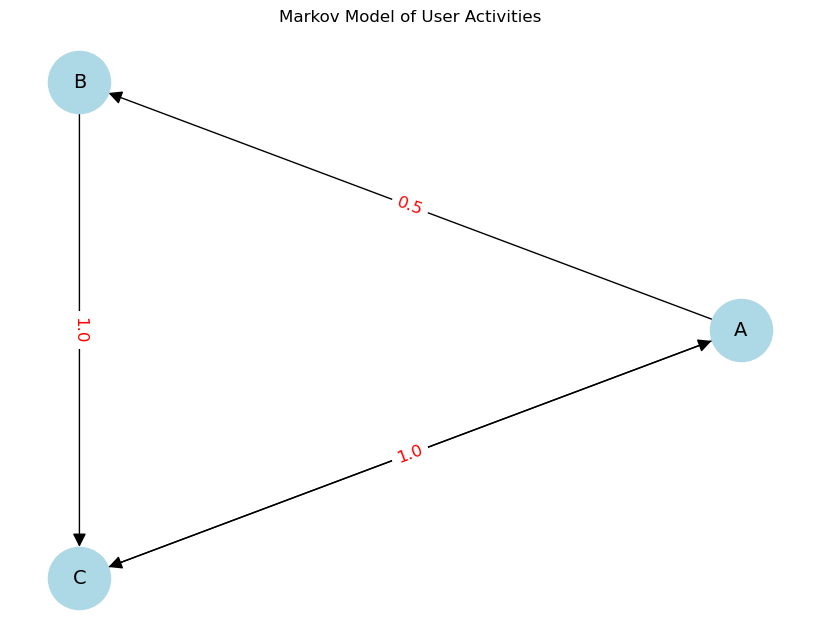

In [11]:
def plot_markov_chain(matrix, labels):
    G = nx.DiGraph()

    # Add nodes
    for label in labels:
        G.add_node(label)

    # Add edges with weights
    for i in range(len(labels)):
        for j in range(len(labels)):
            weight = matrix[i, j]
            if weight > 0:
                G.add_edge(labels[i], labels[j], weight=round(weight, 2))

    pos = nx.circular_layout(G)
    edge_labels = nx.get_edge_attributes(G, 'weight')

    plt.figure(figsize=(8, 6))
    nx.draw(G, pos, with_labels=True, node_size=2000, node_color='lightblue', font_size=14, arrowsize=20)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', font_size=12)
    plt.title("Markov Model of User Activities")
    plt.show()

plot_markov_chain(transition_matrix, activities)
